In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import sys
import glob

In [2]:
speed_of_light=299792458;

In [3]:
summary_file="Events_Test/nova_electron.dat"
event_file="Events_Test/nova_electron_100_33.dat"
prepend_name="nova_hist_"

In [4]:
def find_total(summary_file,run_num):
    with open(summary_file) as sf:
        dats=sf.read().splitlines()
        for i in range(len(dats)):
            line=dats[i].split()
            if len(line)==2 and line[1]==run_num:
                for j in range(len(dats)-i-1):
                    line2 = dats[i+j+1].split()
                    if len(line2) > 4 and line2[0]=="Total":
                        return float(line2[3])
        print("Could not find run " + run_num)
        return -1

def mom(arr):
    return math.sqrt(arr[3]**2+arr[1]**2+arr[2]**2)
    
def cos_theta(arr):
    return math.acos(arr[3]/mom(arr))

#Expect each element of arr to be 4 elements. Expects px py pz E.
def invariant_mass(arr):
    tot = [0,0,0,0]
    for line in arr:
        for i in range(4):
            tot[i]+=line[i]
    return tot[3]**2-tot[0]**2-tot[1]**2-tot[2]**2

In [5]:
def ADP_binning(event_file,summary_file):
    with open(event_file) as ef:
        dat=ef.read().splitlines()
        run_num=''
    
        for line in dat:
            line=line.split()
            if len(line)==2 and line[0]=="Run":
                run_num=line[1]
                break
    
    print("Searching for Run " + run_num)
    nevents = find_total(summary_file,run_num)
    if nevents == -1:
        print("No Histograms to generate.")
        return
    
    print("Run located, " + str(nevents) + " events.")
    

In [6]:
def select_particle(event_file,part_name):
    with open(event_file) as ef:
        dat=ef.read().splitlines()
        
    dat = [line.split() for line in dat]
    sum_line = dat[-1]
    mv=sum_line[1]
    mx=sum_line[2]
    nevents=sum_line[3]
    
    parts = [[float(line[i]) for i in range(1,len(line))] for line in dat if len(line)>2 and line[0]==part_name]
    
    return float(mv),float(mx),float(nevents),parts,event_file

In [7]:
def claudia_binning(nevents,parts):
    energies=[p[0] for p in parts if p[0]<=2]
    eff=len(energies)/len(parts)
    plt.figure(0)
    hist, bin_edges = np.histogram(energies,bins=20,normed=1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    return bin_centers,eff*hist*nevents/(bin_edges[1]-bin_edges[0])
    #plt.bar(bin_centers,hist*nevents,width=bin_edges[1]-bin_edges[0],linewidth=1,edgecolor='black',log=False)
    #plt.show()

In [9]:
def iterateoverfiles(files):
    xy=list()
    for file in files:
        mv,mx,nevents,parts,eventfile=select_particle(file,'electron')
        x,y=claudia_binning(nevents,parts)
        angle=file.split('.dat')[0].split('_')[-1]
        xy+=[[mv,angle,x,y]]
    return xy

In [10]:
def pi0_binning(event_file,summary_file):
    with open(event_file) as ef:
        dat=ef.read().splitlines()
        run_num=''
    
        for line in dat:
            line=line.split()
            if len(line)==2 and line[0]=="Run":
                run_num=line[1]
                break
    
    print("Searching for Run " + run_num)
    nevents = find_total(summary_file,run_num)
    if nevents == -1:
        print("No Histograms to generate.")
        return
    
    print("Run located, " + str(nevents) + " events.")    
    dat2 = [line.split() for line in dat]
    photons=list()
    electrons=list()
    for i in range(len(dat2)):
        if(len(dat2[i])==2 and dat2[i][0]=="event"):
            tmp_phot=[]
            tmp_ele=[]
            for j in range(1,10):
                if len(dat2[i+j])==0:
                    continue
                if dat2[i+j]=='endevent':
                    i+=j+1
                    break
                elif dat2[i+j][0]=='Decay_Photon':
                    tmp_phot = dat2[i+j]
                elif dat2[i+j][0]=='Electron':
                    tmp_ele = dat2[i+j]
                if len(tmp_phot)>1 and len(tmp_ele)>1:
                    photons.append(tmp_phot)
                    electrons.append(tmp_ele)
                    tmp_phot=[]
                    tmp_ele=[]
        else:
            continue
    
    photon = [[float(line[i]) for i in range(1,len(line))] for line in photons]
    electron = [[float(line[i]) for i in range(1,len(line))] for line in electrons]
    pi0 = [invariant_mass([photon[i],electron[i]]) for i in range(len(photon))]
    
    pi02 = [x for x in pi0 if x>0.08**2 and x<0.2**2]
    
    plt.figure(0)
    hist, bin_edges = np.histogram(pi0,bins=20,normed=1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.bar(bin_centers,hist*nevents,width=bin_edges[1]-bin_edges[0],linewidth=1,edgecolor='black',log=False)
    plt.show()

Searching for Run 1538955417
Run located, 25.4512 events.


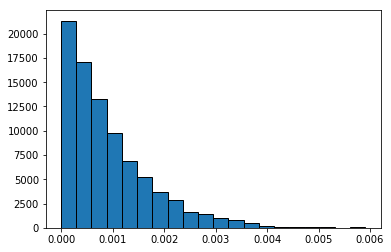

In [88]:
pi0_binning("Events_ADP/mini_0.01.dat","Events_ADP/miniboone_e_3.dat")  

In [8]:
def main(event_file,summary_file):    
    with open(event_file) as ef:
        dat=ef.read().splitlines()
        run_num=''
    
        for line in dat:
            line=line.split()
            if len(line)==2 and line[0]=="Run":
                run_num=line[1]
                break
        print("Searching for Run " + run_num)
        nevents = find_total(summary_file,run_num)
        if nevents == -1:
            print("No Histograms to generate.")
            return
        print("Run located, " + str(nevents) + " events.")
        dat2 = [line.split() for line in dat]
        
        electron = [[float(line[i]) for i in range(1,len(line))] for line in dat2 if len(line)>1 and line[0]=='electron']
        dm = [[float(line[i]) for i in range(1,len(line))] for line in dat2 if len(line)>1 and line[0]=='DM']
        
        eE=[par[3] for par in electron]
        
        cos_t_e=[cos_theta(par[0:3]) for par in electron]
        
        cos_t_dm=[cos_theta(par[0:3]) for par in dm]
        
        plt.figure(0)
        hist, bin_edges = np.histogram(eE,bins=20,normed=1)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        plt.bar(bin_centers,hist*nevents,width=bin_edges[1]-bin_edges[0],linewidth=1,edgecolor='black',log=False)
        plt.xlabel("Energy (GeV)")
        plt.ylabel("Events")
        plt.savefig(prepend_name+'electron_energy.pdf')
        plt.close()
        
        plt.figure(1)
        hist, bin_edges = np.histogram(cos_t_e,bins=10,normed=1)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        plt.bar(bin_centers,hist*nevents,width=bin_edges[1]-bin_edges[0],linewidth=1,edgecolor='black',log=False)
        plt.xlabel("Angle (rad)")
        plt.ylabel("Events")
        plt.savefig(prepend_name+'electron_angle.pdf')
        plt.close()
        
        plt.figure(2)
        hist, bin_edges = np.histogram(cos_t_dm,bins=10,normed=1)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        plt.bar(bin_centers,hist*nevents,width=bin_edges[1]-bin_edges[0],linewidth=1,edgecolor='black',log=False)
        plt.xlabel("Angle (rad)")
        plt.ylabel("Events")
        #plt.savefig(prepend_name+'dm_angle.pdf')
        plt.close()

In [12]:
main(event_file,summary_file)

Searching for Run 1535590500
Run located, 26524300.0 events.


In [9]:
def dm_bin(event_file):    
    with open(event_file) as ef:
        dat=ef.read().splitlines()
        run_num=''
        dat2 = [line.split() for line in dat]
        sum_line=dat2[-1]
        nevents=float(sum_line[8])*float(sum_line[10])
        mv = dat2[-1][1]
        mdm = dat2[-1][2]
        eps = dat2[-1][4]
        #electron = [[float(line[i]) for i in range(1,len(line))] for line in dat2 if len(line)>1 and line[0]=='electron']
        dm = [[float(line[i]) for i in range(3,len(line))] for line in dat2 if len(line)>1 and line[2]=='DM']
        #eE=[par[3] for par in electron]
        #cos_t_e=[cos_theta(par[0:3]) for par in electron]
        #cos_t_dm=[cos_theta(par[0:3]) for par in dm]

        #dmE=[par[0] for par in dm]
        dmE=[1e3*math.sqrt(par[0]**2-float(mdm)**2) for par in dm]        
        
        plt.figure(0)
        hist, bin_edges = np.histogram(dmE,bins=100)
        #return(hist*nevents/1000,bin_edges,nevents)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        plt.bar(bin_centers,hist*nevents/len(dm),width=bin_edges[1]-bin_edges[0],linewidth=1,edgecolor='black',log=False)
        n_low=0
        n_high=0
        #plt.xlim(0,25)
        plt.xlabel("DM Momentum (MeV)")
        plt.ylabel("Intersections")
        plt.text(200,max(hist)*nevents/len(dmE)*0.7,"mv={} GeV\nmdm={} GeV\nalpha_D=0.5\nepsilon=0.001\nTotal Intersections={:.2e}".format(mv,mdm,nevents))
        plt.savefig(prepend_name+'_{}_{}_energy.pdf'.format(mv,mdm))
        #plt.savefig("Fig3.pdf")
        plt.show()
        plt.close()

In [35]:
def recoil_bin_simple(event_file,prepend_name,recoil_target_list,window_min=0,window_max=300,reweight=1):    
    with open(event_file) as ef:
        dat2=ef.read().splitlines()
        run_num=''
        dat2 = [line.split() for line in dat2]
        sum_line=dat2[-1]
        nevents=float(sum_line[1])*reweight
        mv = 1000*float(dat2[-1][2])
        mdm = 1000*float(dat2[-1][3])
        eps = dat2[-1][4]
        alpha_D=dat2[-1][5]
        recoil = []
        for recoil_target in recoil_target_list: 
            recoil+=[[float(line[i]) for i in range(1,len(line))] for line in dat2 if len(line)>1 
                     and line[0]==recoil_target]
        del dat2
        #kE = [1e6*line[13] for line in recoil if 1e6*line[13]<window_max]
        kE = [1e6*line[13] for line in recoil if 1e6*line[13]<window_max]
        del recoil
        #kE = [1e3*math.sqrt(line[1]**2+line[2]**2+line[3]**2) for line in recoil if 1e3*line[13]<window_max]
        plt.figure(0)
        hist, bin_edges = np.histogram(kE,bins=50)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        plt.bar(bin_centers,hist*nevents/len(kE),width=bin_edges[1]-bin_edges[0],linewidth=1,edgecolor='black',log=True)
        n_low=0
        n_high=0
        plt.xlim(window_min,window_max)
        plt.xlabel("Recoil Kinetic Energy (keV)",fontsize=15)
        plt.ylabel("Recoils",fontsize=15)
        #plt.yticks([])
        bottom, top = plt.ylim()
        print(bottom,top,math.log10(top/bottom))
        #plt.plot([50, 50], [0, top],lw=2, color="k")
        #plt.text(window_max/3.3,top*0.8,"Dark Photon Mass={} MeV\nDark Matter Mass={} MeV".format(mv,mdm,alpha_D,eps,nevents),fontsize=15)
        plt.text(window_max/1.5,math.exp(math.log(top/bottom)*0.8+math.log(bottom)),"M$_\mathrm{DM}$"+"={} MeV".format(round(mdm))+"\nM$_\mathrm{V}$"+"={} MeV".format(round(mv)),fontsize=15)
        #plt.text(51,top*0.60,r"$\leftarrow$50 keV",fontsize=15)
        #plt.vlines(20,0,25000,lw=2,color='b')
        plt.tight_layout()
        plt.ylim(top=top)
        plt.savefig(prepend_name+'_{}_{}_recoil.pdf'.format(mv,mdm))
        plt.show()
        plt.close()

28.495046553828097 89801618.05975501 6.498514791084719


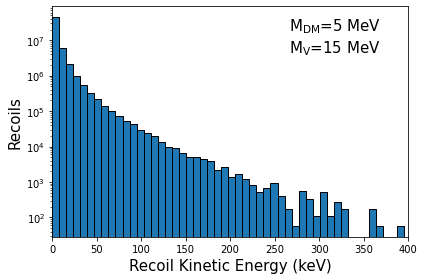

In [36]:
recoil_bin_simple("CCM_Events/CCM_NEW_Ar_15","CCM_Events/CCM_Recoil",["Argon"], window_min=0,window_max=400)

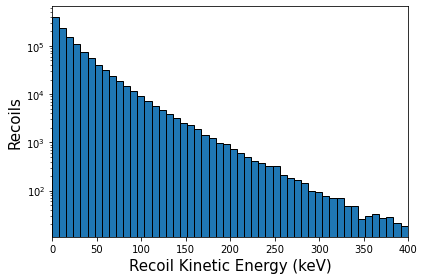

In [13]:
recoil_bin_simple("CCM_Events/CCM_NEW_Ar_60","CCM_Events/CCM_Recoil_",["Argon"], window_min=0,window_max=400)

In [26]:
math.exp(math.log(top/bottom)*0.8+math.log(bottom))

5.197632272037717

0.2709210960212552 920.0759466171625 3.5309808532745084


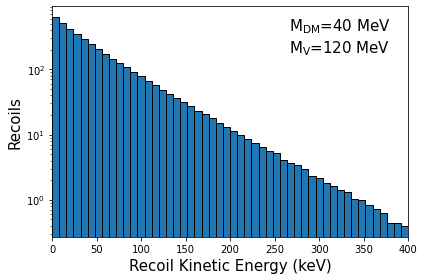

In [37]:
recoil_bin_simple("CCM_Events/CCM_NEW_Ar_120","CCM_Events/CCM_Recoil_",["Argon"], window_min=0,window_max=400)

In [5]:
def recoil_mom(event_file,recoil_target_list,window_min=0,window_max=3,reweight=1):    
    with open(event_file) as ef:
        dat=ef.read().splitlines()
        run_num=''
        dat2 = [line.split() for line in dat]
        sum_line=dat2[-1]
        nevents=float(sum_line[1])*reweight
        mv = 1000*float(dat2[-1][2])
        mdm = 1000*float(dat2[-1][3])
        eps = dat2[-1][4]
        alpha_D=dat2[-1][5]
        recoil = []
        for recoil_target in recoil_target_list: 
            recoil+=[[float(line[i]) for i in range(1,len(line))] for line in dat2 if len(line)>1 
                     and line[0]==recoil_target]
        #kE = [1e6*line[13] for line in recoil if 1e6*line[13]<window_max]
        #return recoil
        #kE = [1e3*line[13] for line in recoil if 1e3*line[13]<window_max]
        kE = [math.sqrt(line[1]**2+line[2]**2+line[3]**2) for line in recoil if line[13]<window_max]
        plt.figure(0)
        hist, bin_edges = np.histogram(kE,bins=50)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        plt.bar(bin_centers,hist*nevents/len(kE),width=bin_edges[1]-bin_edges[0],linewidth=1,edgecolor='black',log=False)
        n_low=0
        n_high=0
        plt.xlim(window_min,window_max)
        plt.xlabel("Recoil Momentum (GeV)",fontsize=15)
        plt.ylabel("Recoils",fontsize=15)
        #plt.yticks([])
        bottom, top = plt.ylim()
        #plt.plot([50, 50], [0, top],lw=2, color="k")
        #plt.text(window_max/3.3,top*0.8,"Dark Photon Mass={} MeV\nDark Matter Mass={} MeV".format(mv,mdm,alpha_D,eps,nevents),fontsize=15)
        #plt.text(51,top*0.60,r"$\leftarrow$50 keV",fontsize=15)
        #plt.vlines(20,0,25000,lw=2,color='b')
        plt.tight_layout()
        plt.ylim(top=top)
        plt.savefig(prepend_name+'_{}_{}_recoil.pdf'.format(mv,mdm))
        plt.show()
        plt.close()

In [6]:
prepend_name = "CCM_Events/CCM_Recoil_"

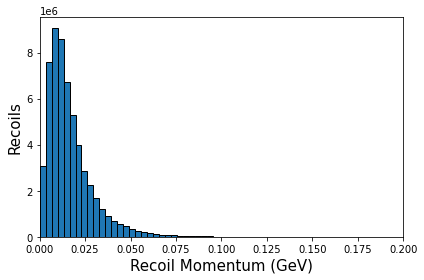

In [15]:
recoil_mom("CCM_Events/CCM_NEW_Ar_15",["Argon"], window_min=0,window_max=0.2)

In [115]:
prepend_name = "T2K_hist/p0d_momentum"

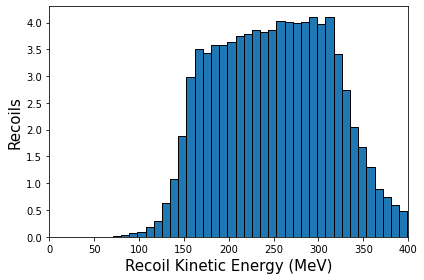

In [116]:
recoil_bin_simple("T2K_Events/t2k_p0d_180_60.0.dat",["pi0"],
                  window_min=0,window_max=400,reweight=8/5)

In [155]:
prepend_name = "T2K_hist/fgd_nucleon_mom"

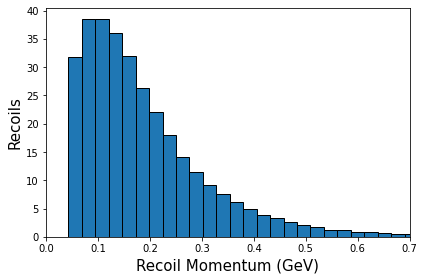

In [158]:
recoil_mom("T2K_Events/t2k_fgd_nucleon_180_60.0.dat",["neutron","proton"],
                  window_min=0,window_max=0.7,reweight=8/5)

In [172]:
prepend_name = "T2K_hist/fgd_electron_mom"

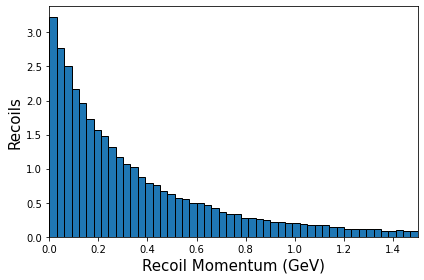

In [173]:
recoil_mom("T2K_Events/t2k_fgd_electron_30_10.0.dat",["electron"],
                  window_min=0,window_max=1.500,reweight=8/5/10**4)

In [174]:
def recoil_angle(event_file,recoil_target_list,window_min=0.95,window_max=1,reweight=1):    
    with open(event_file) as ef:
        dat=ef.read().splitlines()
        run_num=''
        dat2 = [line.split() for line in dat]
        sum_line=dat2[-1]
        nevents=float(sum_line[1])*reweight
        print(nevents)
        mv = dat2[-1][2]
        mdm = dat2[-1][3]
        eps = dat2[-1][4]
        recoil = [];
        for recoil_target in recoil_target_list:
            recoil += [[float(line[i]) for i in range(1,len(line))] for line in dat2 if len(line)>1
                  and line[0]==recoil_target]
        cos_t_e = [line[3]/mom(line[0:4]) for line in recoil]
        cos_t_e = [x for x in cos_t_e if x > window_min and x < window_max]
        #angle = [numpy.arccos(cos) for cos in cos_t_e]
        plt.figure(0)
        hist, bin_edges = np.histogram(cos_t_e,bins=50)
        #return(hist*nevents/1000,bin_edges,nevents)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        #return mv,mdm,hist,bin_centers
        print(nevents)
        plt.bar(bin_centers,hist*nevents/len(cos_t_e),width=bin_edges[1]-bin_edges[0],linewidth=1,edgecolor='black',log=False)
        n_low=0
        n_high=0
        plt.xlim(window_min,window_max)
        plt.xlabel("Cos(Recoil Angle)",fontsize=15)
        plt.ylabel("Recoils",fontsize=15)
        #plt.text((window_min+window_max)/2,max(hist)*nevents/len(cos_t_e)*0.7,"mv={} GeV\nmdm={} GeV\nalpha_D=0.5\nepsilon=0.001\nTotal Recoils={:.2e}".format(mv,mdm,nevents))
        plt.savefig(prepend_name+'_{}_{}_recoil.pdf'.format(mv,mdm))
        plt.show()
        #plt.close()

In [101]:
prepend_name = "T2K_hist/p0d_angle"

88.005884128


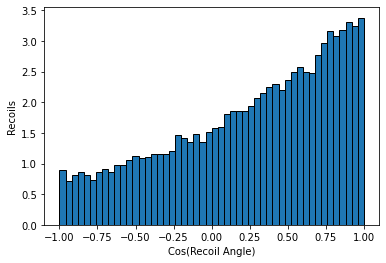

In [102]:
recoil_angle("T2K_Events/t2k_p0d_180_60.0.dat",["pi0"],reweight=8/5)

33.70444628800001
33.70444628800001


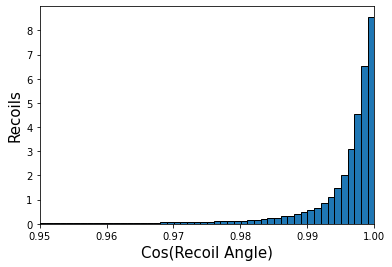

In [175]:
prepend_name = "T2K_hist/fgd_electron_angle"
recoil_angle("T2K_Events/t2k_fgd_electron_30_10.0.dat",["electron"],
                  window_min=0.95,reweight=8/5/10**4)

317.98797408


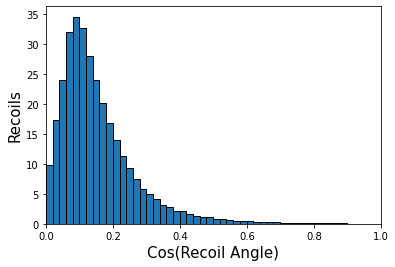

In [163]:
prepend_name = "T2K_hist/fgd_nucleon_angle"
recoil_angle("T2K_Events/t2k_fgd_nucleon_180_60.0.dat",["proton","electron"],
                  window_min=0,reweight=8/5)

In [197]:
prepend_name = "T2K_hist/t2k_hyperk_nucleon_angle"

417.43329652799997
417.43329652799997


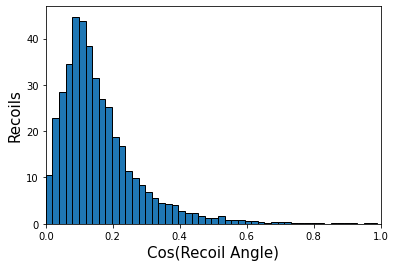

In [198]:
recoil_angle("T2K_Events/t2k_superk_nucleon_notime_180_60.0.dat",["proton","neutron"],window_min=0,reweight=27/5*20)

In [62]:
def timing_delay(event_file,recoil_target_list,window_min=0,window_max=300,reweight=1):    
    with open(event_file) as ef:
        dat=ef.read().splitlines()
        run_num=''
        dat2 = [line.split() for line in dat]
        sum_line=dat2[-1]
        nevents=float(sum_line[1])*reweight
        mv = 1000*float(dat2[-1][2])
        mdm = 1000*float(dat2[-1][3])
        eps = dat2[-1][4]
        alpha_D=dat2[-1][5]
        recoil = []
        for recoil_target in recoil_target_list: 
            recoil+=[[float(line[i]) for i in range(1,len(line))] for line in dat2 if len(line)>1 
                     and line[0]==recoil_target]
        #kE = [1e6*line[13] for line in recoil if 1e6*line[13]<window_max]
        #return recoil
        time_delay = [1e9*(line[8]-math.sqrt(line[5]**2+line[6]**2+line[7]**2)/speed_of_light) for line in recoil]
        time_delay = [x for x in time_delay if x<window_max]
        plt.figure(0)
        hist, bin_edges = np.histogram(time_delay,bins=50)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        plt.bar(bin_centers,hist*nevents/len(time_delay),width=bin_edges[1]-bin_edges[0],linewidth=1,edgecolor='black',log=False)
        n_low=0
        n_high=0
        plt.xlim(window_min,window_max)
        plt.xlabel("Time Delay (ns)",fontsize=15)
        plt.ylabel("Recoils",fontsize=15)
        #plt.yticks([])
        bottom, top = plt.ylim()
        #plt.plot([50, 50], [0, top],lw=2, color="k")
        #plt.text(window_max/3.3,top*0.8,"Dark Photon Mass={} MeV\nDark Matter Mass={} MeV".format(mv,mdm,alpha_D,eps,nevents),fontsize=15)
        #plt.text(51,top*0.60,r"$\leftarrow$50 keV",fontsize=15)
        #plt.vlines(20,0,25000,lw=2,color='b')
        plt.tight_layout()
        plt.ylim(top=top)
        plt.savefig(prepend_name+'_{}_{}_recoil.pdf'.format(mv,mdm))
        plt.show()
        plt.close()

In [61]:
prepend_name = "T2K_hist/hyperk_nucleon_timing_delay"

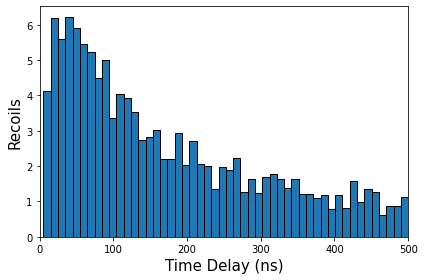

In [63]:
timing_delay("T2K_Events/t2k_superk_nucleon_notime_180_60.0.dat",["proton","neutron"],window_max=500,reweight=8/5*20)

In [ ]:
def recoil_bin_simple(event_file,recoil_target_list,window_min=0,window_max=300,reweight=1):    
    with open(event_file) as ef:
        dat=ef.read().splitlines()
        run_num=''
        dat2 = [line.split() for line in dat]
        sum_line=dat2[-1]
        nevents=float(sum_line[1])*reweight
        mv = 1000*float(dat2[-1][2])
        mdm = 1000*float(dat2[-1][3])
        eps = dat2[-1][4]
        alpha_D=dat2[-1][5]
        recoil = []
        for recoil_target in recoil_target_list: 
            recoil+=[[float(line[i]) for i in range(1,len(line))] for line in dat2 if len(line)>1 
                     and line[0]==recoil_target]
        #kE = [1e6*line[13] for line in recoil if 1e6*line[13]<window_max]
        #return recoil
        kE = [1e3*line[13] for line in recoil if 1e3*line[13]<window_max]
        plt.figure(0)
        hist, bin_edges = np.histogram(kE,bins=50)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        plt.bar(bin_centers,hist*nevents/len(kE),width=bin_edges[1]-bin_edges[0],linewidth=1,edgecolor='black',log=False)
        n_low=0
        n_high=0
        plt.xlim(window_min,window_max)
        plt.xlabel("Recoil Kinetic Energy (MeV)",fontsize=15)
        plt.ylabel("Recoils",fontsize=15)
        #plt.yticks([])
        bottom, top = plt.ylim()
        #plt.plot([50, 50], [0, top],lw=2, color="k")
        #plt.text(window_max/3.3,top*0.8,"Dark Photon Mass={} MeV\nDark Matter Mass={} MeV".format(mv,mdm,alpha_D,eps,nevents),fontsize=15)
        #plt.text(51,top*0.60,r"$\leftarrow$50 keV",fontsize=15)
        #plt.vlines(20,0,25000,lw=2,color='b')
        plt.tight_layout()
        plt.ylim(top=top)
        plt.savefig(prepend_name+'_{}_{}_recoil.pdf'.format(mv,mdm))
        plt.show()
        plt.close()

In [61]:
def custom(event_file,summary_file):    
    with open(event_file) as ef:
        dat=ef.read().splitlines()
        run_num=''
        for line in dat:
            line=line.split()
            if len(line)==2 and line[0]=="Run":
                run_num=line[1]
                break
        print("Searching for Run " + run_num)
        nevents = find_total(summary_file,run_num)
        if nevents == -1:
            print("No Histograms to generate.")
            return
        print("Run located, " + str(nevents) + " events.")
        dat2 = [line.split() for line in dat]
        mv = dat2[-1][1]
        mdm = dat2[-1][2]
        electron = [[float(line[i]) for i in range(1,len(line))] for line in dat2 if len(line)>1 and line[0]=='Argon']
        dm = [[float(line[i]) for i in range(1,len(line))] for line in dat2 if len(line)>1 and line[0]=='DM']
        eE=[par[-1]*1e6 for par in electron]
        eE=[En for En in eE if En<1000]
        #return(eE)
        cos_t_e=[cos_theta(par[0:3]) for par in electron]
        
        cos_t_dm=[cos_theta(par[0:3]) for par in dm]
        
        plt.figure(0)
        hist, bin_edges = np.histogram(eE,bins=30,normed=1)
        return(hist*nevents/1000,bin_edges,nevents)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        plt.bar(bin_centers,hist*nevents,width=bin_edges[1]-bin_edges[0],linewidth=1,edgecolor='black',log=False)
        plt.xlim(0,600)
        plt.xlabel("Recoil Energy (keV)")
        plt.ylabel("Events/keV/1E22POT")
        plt.text(300,max(hist*nevents)*0.7,"mv={} GeV\nmdm={} GeV\nalpha_D=0.5\nepsilon=0.001\nTotal Events={}".format(mv,mdm,nevents))
        plt.savefig(prepend_name+'_{}_{}_recoil_energy.pdf'.format(mv,mdm))
        plt.show()
        plt.close()

In [62]:
def custom2d(event_file,summary_file):    
    with open(event_file) as ef:
        dat=ef.read().splitlines()
        run_num=''
        for line in dat:
            line=line.split()
            if len(line)==2 and line[0]=="Run":
                run_num=line[1]
                break
        print("Searching for Run " + run_num)
        nevents = find_total(summary_file,run_num)
        if nevents == -1:
            print("No Histograms to generate.")
            return
        print("Run located, " + str(nevents) + " events.")
        dat2 = [line.split() for line in dat]
        mv = dat2[-1][1]
        mdm = dat2[-1][2]
        recoil = [[float(line[i]) for i in range(1,len(line))] for line in dat2 if len(line)>1 and line[0]=='Argon']
        recoil = [line for line in recoil if line[-1]*1e6<1000]
        #dm = [[float(line[i]) for i in range(1,len(line))] for line in dat2 if len(line)>1 and line[0]=='DM']
        eE=[par[-1]*1e6 for par in recoil]
        #return(eE)
        eTime=[par[-2]*1e9 for par in recoil]
        #cos_t_e=[cos_theta(par[0:3]) for par in recoil]
        #cos_t_dm=[cos_theta(par[0:3]) for par in dm]
        plt.figure(0)
        hist, bin_edges_x, bin_edges_y = np.histogram2d(eE,eTime,bins=30,normed=1)
        return(hist*nevents/1000,bin_edges_x,bin_edges_y,nevents)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        plt.bar(bin_centers,hist*nevents/1000,width=bin_edges[1]-bin_edges[0],linewidth=1,edgecolor='black',log=False)
        plt.xlim(0,600)
        plt.xlabel("Recoil Energy (keV)")
        plt.ylabel("Events/keV/1E22POT/kg/ns")
        plt.text(300,max(hist*nevents)*0.7,"mv={} GeV\nmdm={} GeV\nalpha_D=0.5\nepsilon=0.001\nTotal Events={}".format(mv,mdm,nevents))
        plt.savefig(prepend_name+'_{}_{}_recoil_energy.pdf'.format(mv,mdm))
        plt.show()
        plt.close()

In [60]:
if '__name__' == '__main__':
    if(len(sys.arg)>=2):
        main(sys.arg[0],sys.arg[1])
    else:
        print("bdnmc_hist <event_file> <summary_file>")

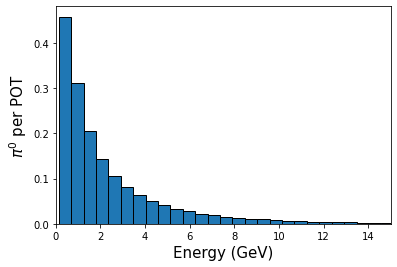

In [93]:
event_file = "data/pythia_pi0_30gev.dat"
with open(event_file) as ef:
        dat=ef.read().splitlines()
        dat = [line.split() for line in dat]
        e_list = [float(line[3]) for line in dat]
        hist, bin_edges = np.histogram(e_list,bins=50)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        plt.bar(bin_centers,hist*1.67/len(e_list),width=bin_edges[1]-bin_edges[0],linewidth=1,edgecolor='black',log=False)
        plt.xlim(0,15)
        plt.xlabel("Energy (GeV)",fontsize=15)
        plt.ylabel("$\pi^0$ per POT",fontsize=15)
        plt.savefig("T2K_hist/pi0_E.pdf")
        plt.show()

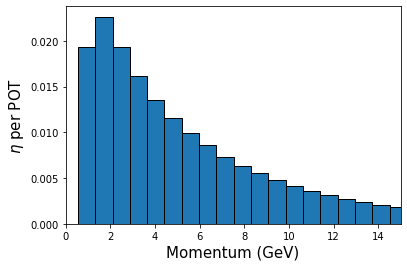

In [170]:
event_file = "data/pythia_eta_30gev.dat"
with open(event_file) as ef:
        dat=ef.read().splitlines()
        dat = [line.split() for line in dat]
        #e_list = [float(line[3]) for line in dat]
        mom_list = [math.sqrt(float(line[1])**2+float(line[2])**2+float(line[3])**2) for line in dat]
        hist, bin_edges = np.histogram(mom_list,bins=50)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        plt.bar(bin_centers,hist*0.178/len(mom_list),width=bin_edges[1]-bin_edges[0],linewidth=1,edgecolor='black',log=False)
        plt.xlim(0,15)
        plt.xlabel("Momentum (GeV)",fontsize=15)
        plt.ylabel("$\eta$ per POT",fontsize=15)
        plt.savefig("T2K_hist/eta_E.pdf")
        plt.show()

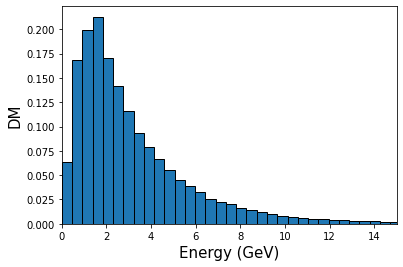

In [146]:
event_file = "T2K_Events/t2k_fgd_dm_180_60.0.dat"
with open(event_file) as ef:
        dat=ef.read().splitlines()
        dat = [line.split() for line in dat]
        e_list = [float(line[3]) for line in dat]
        hist, bin_edges = np.histogram(e_list,bins=50)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        plt.bar(bin_centers,hist*1.67/len(e_list),width=bin_edges[1]-bin_edges[0],linewidth=1,edgecolor='black',log=False)
        plt.xlim(0,15)
        plt.xlabel("Energy (GeV)",fontsize=15)
        plt.ylabel("DM",fontsize=15)
        plt.savefig("T2K_hist/DM_fgd_E_60mev.pdf")
        plt.show()

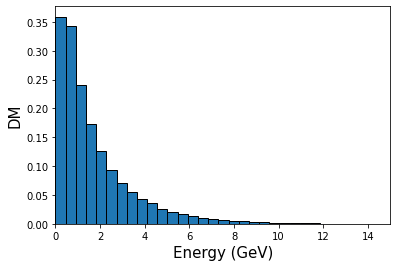

In [147]:
event_file = "T2K_Events/t2k_fgd_dm_30_10.0.dat"
with open(event_file) as ef:
        dat=ef.read().splitlines()
        dat = [line.split() for line in dat]
        e_list = [float(line[3]) for line in dat]
        hist, bin_edges = np.histogram(e_list,bins=50)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        plt.bar(bin_centers,hist*1.67/len(e_list),width=bin_edges[1]-bin_edges[0],linewidth=1,edgecolor='black',log=False)
        plt.xlim(0,15)
        plt.xlabel("Energy (GeV)",fontsize=15)
        plt.ylabel("DM",fontsize=15)
        plt.savefig("T2K_hist/DM_fgd_E_10mev.pdf")
        plt.show()

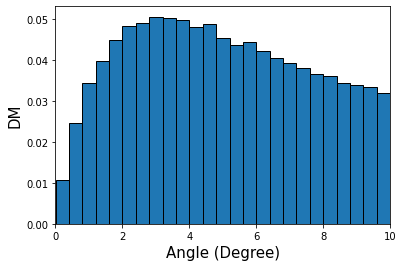

In [194]:
event_file = "T2K_Events/t2k_dm_dist_180_60.0.dat"
window_min=0
window_max=10
with open(event_file) as ef:
        dat=ef.read().splitlines()
        dat = [line.split() for line in dat]
        dat = dat[0:-2]
        dat = [[float(line[i]) for i in range(3,len(line))] for line in dat if len(line)>1]
        dat2 = [math.acos(line[3]/mom(line[0:4]))*180/math.pi for line in dat]
        dat2 = [x for x in dat2 if x > window_min and x < window_max]
        hist, bin_edges = np.histogram(dat2,bins=25)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        plt.bar(bin_centers,hist/len(dat2),width=bin_edges[1]-bin_edges[0],linewidth=1,edgecolor='black',log=False)
        plt.xlim(window_min,window_max)
        plt.xlabel("Angle (Degree)",fontsize=15)
        plt.ylabel("DM",fontsize=15)
        plt.savefig("T2K_hist/DM_angle_60mev.pdf")
        plt.show()

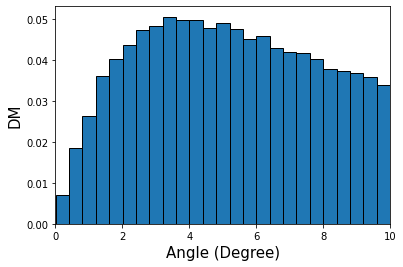

In [195]:
event_file = "T2K_Events/t2k_dm_dist_30_10.0.dat"
window_min=0
window_max=10
with open(event_file) as ef:
        dat=ef.read().splitlines()
        dat = [line.split() for line in dat]
        dat = dat[0:-2]
        dat = [[float(line[i]) for i in range(3,len(line))] for line in dat if len(line)>1]
        dat2 = [math.acos(line[3]/mom(line[0:4]))*180/math.pi for line in dat]
        dat2 = [x for x in dat2 if x > window_min and x < window_max]
        hist, bin_edges = np.histogram(dat2,bins=25)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        plt.bar(bin_centers,hist/len(dat2),width=bin_edges[1]-bin_edges[0],linewidth=1,edgecolor='black',log=False)
        plt.xlim(window_min,window_max)
        plt.xlabel("Angle (Degree)",fontsize=15)
        plt.ylabel("DM",fontsize=15)
        plt.savefig("T2K_hist/DM_angle_10mev.pdf")
        plt.show()